In [2]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import rfft, irfft, rfftfreq

import analysis_utils as utils
import importlib

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [3]:
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

m = 2000 * (83.5e-9)**3 * 4 * np.pi / 3
hbar = 6.626e-34

In [18]:
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

## Calibration factor after realigning and higher LO power

In [4]:
def get_area_driven_peak(ffd, ppd, passband=(88700, 89300), noise_floor=None, plot=False):
    """Calculate PSD then integrate over passband"""
    if noise_floor is None:
        noise_idx = np.logical_and(ffd > 100000, ffd < 105000)
        noise_floor = np.mean(ppd[noise_idx])
    
    all_idx = np.logical_and(ffd > passband[0], ffd < passband[1])
    area_all = np.trapz(ppd[all_idx]-noise_floor, ffd[all_idx]*2*np.pi)
    v2_drive = area_all / (2 * np.pi)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(ffd[all_idx], ppd[all_idx])
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Spectral density ($V^2 / Hz$)')
        ax.set_yscale('log')

    if plot:
        plt.show()

    return v2_drive

def get_c_mv(data_files_ordered, vp2p, omegad, passband, charge=3):
    m = 2000 * (83.5e-9**3) * (4 / 3) * np.pi  # sphere mass
    
    ffss, ppss = [], []
    for file in data_files_ordered:
        dtt, tt, nn = utils.load_timestreams(file, ['D'])
        zz = nn[0]

        size_per_chunk = int(zz.size / 10)
        ffs, pps = [], []

        for i in range(10):
            ff, pp = utils.get_psd(dt=dtt, zz=zz[i*size_per_chunk : (i+1)*size_per_chunk], nperseg=2**16)
            ffs.append(ff)
            pps.append(pp)

        ffss.append(ffs)
        ppss.append(pps)
        
    c_cals = []
    for i, vpp in enumerate(vp2p):
        fd0 = (vpp / 2) * 120 * charge * 1.6e-19

        c_cal = []
        for j, ff in enumerate(ffss[i]):
            pp = ppss[i][j]
            v2_drive = get_area_driven_peak(ff, pp, passband=passband, plot=False)

            idx_band = np.logical_and(ff > 40000, ff < 80000)
            omega0 = 2 * np.pi * ff[idx_band][np.argmax(pp[idx_band])]
            z2_drive = (fd0**2 / 2) / ((m * (omega0**2 - omegad**2))**2)

            c_cal.append(v2_drive / z2_drive)
        c_cals.append(c_cal)
    
    return np.sqrt(1 / np.asarray(c_cals))

In [5]:
def get_unnormalized_amps(folder, datasets, pulseamps, noise=False):
    unnormalized_amps = []
    for i, dataset in enumerate(datasets):
        print(dataset)
        combined_path = os.path.join(folder, dataset, '**/*.mat')
        data_files = glob.glob(combined_path)

        unnormalized_amps.append(utils.get_unnormalized_amps(data_files, noise))
        
    return unnormalized_amps

def fit_amps_gaus(normalized_amps, noise=False):
    hhs, bcs, gps = [], [], []
    for amp in normalized_amps:
        bins = np.linspace(0, np.max(amp)*1.5, 50)
        hh, be = np.histogram(amp, bins=bins)
        bc = 0.5 * (be[1:] + be[:-1])
        
#         if noise:
#             gp, gcov = curve_fit(utils.gauss, bc, hh, p0=[np.max(hh), 0, np.std(np.abs(amp))], maxfev=5000)
#         else:
        gp, gcov = curve_fit(utils.gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(amp)), np.std(np.abs(amp))], maxfev=5000)

        hhs.append(hh)
        bcs.append(bc)
        gps.append(gp)
    return hhs, bcs, gps

def plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, noise=False, title=None, fig=None, ax=None, color=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    xx = np.linspace(0, np.max(np.asarray(bcs).flatten()), 1000)

    for i, _ in enumerate(normalized_amps):
        if color is None:
            color = yale_colors[i]
        ax.errorbar(bcs[i], hhs[i], yerr=np.sqrt(hhs[i]), fmt='o', color=color)
        if noise:
            ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
        else:
            ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV, $\sigma$ = {gps[i][2]:.1f} keV', color=color)

    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('Reconstruced pulse (keV/c)', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.legend(fontsize=14)
    
    return fig, ax

<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1514/3291782344.py:39: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1514/3291782344.py:41: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV, $\sigma$ = {gps[i][2]:.1f} keV', color=color)


In [6]:
folder = r'/Users/yuhan/work/nanospheres/data/20241001_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20241001_*_97khz_*.mat')
data_files = glob.glob(combined_path)

In [7]:
vp2p = [0.5, 1, 1.5, 2]

order = [3, 0, 2, 1]
data_files_ordered_97khz = [data_files[i] for i in order]

In [8]:
folder = r'/Users/yuhan/work/nanospheres/data/20241001_force_calibration'
dataset = r''
combined_path = os.path.join(folder, dataset, '20241001_*_89khz_*.mat')
data_files = glob.glob(combined_path)

In [9]:
order = [3, 1, 2, 0]
data_files_ordered_89khz = [data_files[i] for i in order]

In [10]:
c_mv_89khz = get_c_mv(data_files_ordered_89khz, vp2p, 89000 * 2 * np.pi, passband=(88700, 89300), charge=3)
c_mv_97khz = get_c_mv(data_files_ordered_97khz, vp2p, 97000 * 2 * np.pi, passband=(96700, 97300), charge=3)

In [11]:
means_89khz = np.mean(np.asarray(c_mv_89khz), axis=1)
errors_89khz = np.sqrt(np.var(np.asarray(c_mv_89khz), axis=1) / (10-1))

means_97khz = np.mean(np.asarray(c_mv_97khz), axis=1)
errors_97khz = np.sqrt(np.var(np.asarray(c_mv_97khz), axis=1) / (10-1))

The averaged calibration factor $C_{mV}$ = 5.565e-08


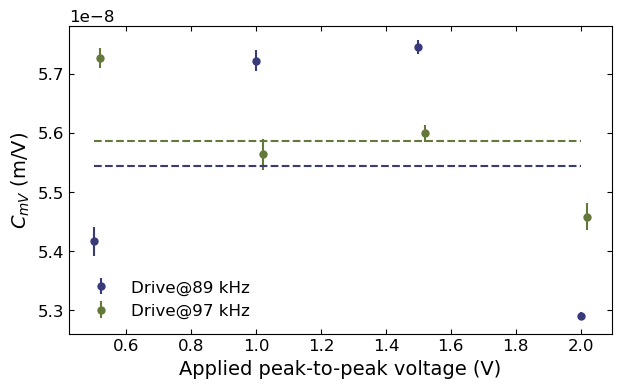

In [12]:
colors = plt.colormaps.get_cmap('tab20b').resampled(6).colors
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.errorbar(vp2p, means_89khz, yerr=errors_89khz, fmt='.', markersize=10, label='Drive@89 kHz')
ax.errorbar(np.asarray(vp2p)+0.02, means_97khz, yerr=errors_97khz, fmt='.', markersize=10, label='Drive@97 kHz')

ax.hlines(np.mean(means_89khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[0])
ax.hlines(np.mean(means_97khz), vp2p[0], vp2p[-1], linestyle='--', color=colors[1])

ax.set_xlabel('Applied peak-to-peak voltage (V)')
ax.set_ylabel('$C_{mV}$ (m/V)')

# ax.set_ylim(9.3e-8, 1e-7)
ax.legend(frameon=False)

c_mv = 0.5 * (np.mean(means_89khz) + np.mean(means_97khz))
print(fr'The averaged calibration factor $C_{{mV}}$ = {c_mv:.3e}')

In [13]:
file = r'/Users/yuhan/work/nanospheres/data/20241001_force_calibration/20241001_noefield_2e-8mbar.mat'
dtt, tt, nn = utils.load_timestreams(file, ['D'])
fs = int(np.ceil(1/dtt))

zz = nn[0]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

In [61]:
popt

array([7.00333183e-06, 3.95895002e+05, 4.48878965e+00, 3.53349423e-27])

<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1514/2624882167.py:25: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[2]/(2*np.pi):.1f} Hz\n'\


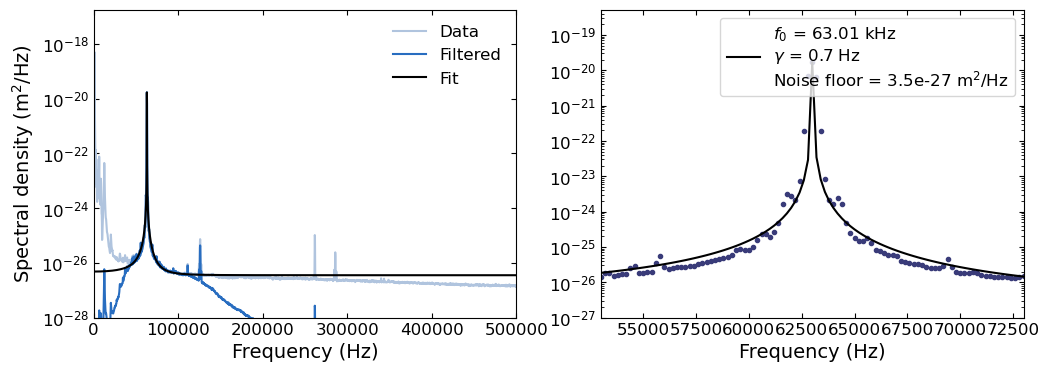

In [67]:
ccal = 1 / (c_mv**2)
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=50000)
ffz_bp, ppz_bp = utils.get_psd(dt=dtt, zz=zz_bp, nperseg=50000)

# Fit with a voigt profile
# popt = utils.fit_z_peak(ffz_bp, ppz_bp, utils.log_voigt, (53000, 73000), [1e-5, 63000*2*np.pi, 100, 1], False)
popt = utils.fit_z_peak(ffz_bp, ppz_bp/ccal, utils.log_lorentzian_with_const, (40000, 100000), p0=[7e-6, 63000*2*np.pi, 20*2*np.pi, 1e-27], plot=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ffz, ppz/ccal, 'lightsteelblue', label='Data')
axes[0].plot(ffz_bp, ppz_bp/ccal, yale_colors[1], label='Filtered')
axes[0].plot(ffz, np.exp(utils.log_lorentzian_with_const(ffz*2*np.pi, *popt)), 'k', label='Fit')
axes[0].set_yscale('log')
axes[0].set_xlim(0, 500000)
axes[0].set_ylim(1e-28)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Spectral density (m$^2$/Hz)')
axes[0].legend(frameon=False)

# label = (f'$f_0$ = {popt[1]/(2*np.pi*1000):.2f} kHz\n'\
#          f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
#          f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')
label = (f'$f_0$ = {popt[1]/(2*np.pi*1000):.2f} kHz\n'\
         f'$\gamma$ = {popt[2]/(2*np.pi):.1f} Hz\n'\
         f'Noise floor = {popt[3]:.1e} m$^2$/Hz')
axes[1].plot(ffz_bp, ppz_bp/ccal, '.', yale_colors[1])
axes[1].plot(ffz, np.exp(utils.log_lorentzian_with_const(ffz*2*np.pi, *popt)), 'k', label=label)
axes[1].set_yscale('log')
axes[1].set_xlim(53000, 73000)
axes[1].set_ylim(1e-27)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].legend(frameon=True)

<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1514/306270776.py:17: SyntaxWarning: invalid escape sequence '\e'
  ax.text(50, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {2.13e-27 / noise_floor:.2f} (?)', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1514/306270776.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.text(50, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {2.13e-27 / noise_floor:.2f} (?)', fontsize=12)


Text(50, 1.75e-28, '$\\eta_{z}$ $\\simeq$ 0.60 (?)')

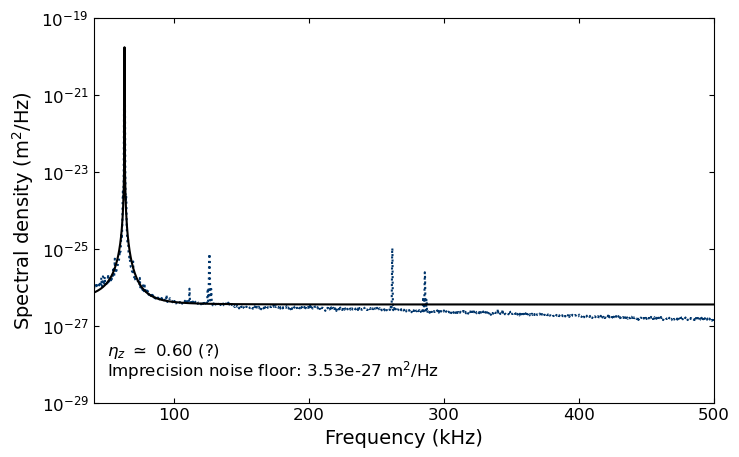

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

noise_floor = popt[3]

ax.plot(ffz/1000, ppz/ccal, ':',color=yale_colors[0])
ax.plot(ffz/1000, np.exp(utils.log_lorentzian_with_const(ffz*2*np.pi, *popt)), 'k', label='Fit')

ax.set_yscale('log')
ax.set_ylim(1e-29, 1e-19)
ax.set_xlim(40, 500)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Spectral density (m$^2$/Hz)')

noise_floor = popt[3]
ax.text(50, 0.5e-28, f'Imprecision noise floor: {noise_floor:.2e} m$^2$/Hz', fontsize=12)
ax.text(50, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {2.13e-27 / noise_floor:.2f} (?)', fontsize=12)

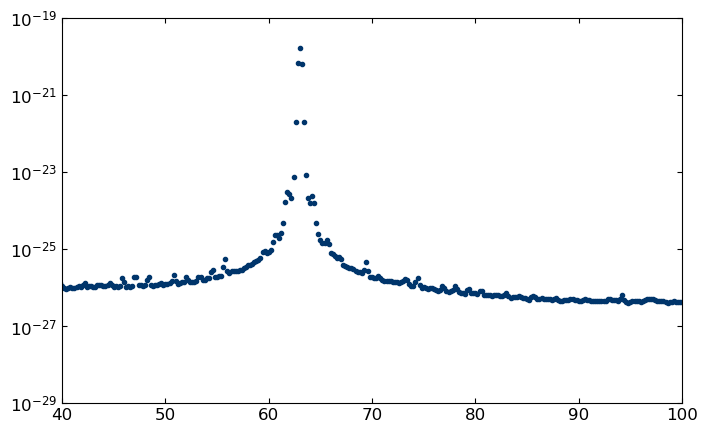

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(ffz/1000, ppz/ccal, '.', color=yale_colors[0])
ax.set_yscale('log')
ax.set_ylim(1e-29, 1e-19)
ax.set_xlim(40, 100)

noise_idx = np.logical_and(ffz/1000 > 95, ffz/1000 < 100)
noise_floor = np.mean(ppz[noise_idx]/ccal)

# ax.set_xlabel('Frequency (kHz)')
# ax.set_ylabel('Spectral density (m$^2$/Hz)')


# print(noise_floor)
# ax.text(400, 0.5e-28, 'Imprecision noise floor: $2.77 \\times 10^{-27}$ m$^2$/Hz', fontsize=12)
# ax.text(400, 1.75e-28, f'$\eta_{{z}}$ $\simeq$ {1.07684193474913e-27 / noise_floor:.2f} (?)', fontsize=12)

In [47]:
2.15368386949826e-27 / noise_floor

0.4787573416463704

## Look at data with shorter pulses

In [87]:
folder = r'/Users/yuhan/work/nanospheres/data/20241001_six_e_data_backscatter'
dataset = r'20241001_10v_2e-8mbar_0_2_analog_gain'
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

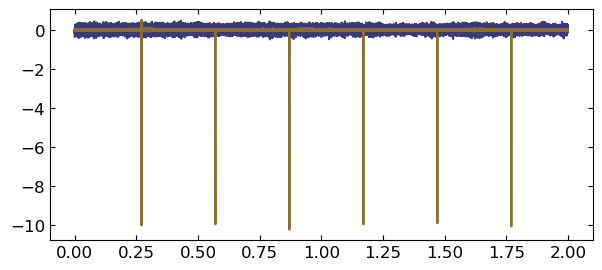

In [89]:
dtt, tt, nn = utils.load_timestreams(data_files[0], ['D', 'G'])

fs = int(np.ceil(1/dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

plt.plot(tt, zz)
plt.plot(tt, zz_bp)
plt.plot(tt, dd)

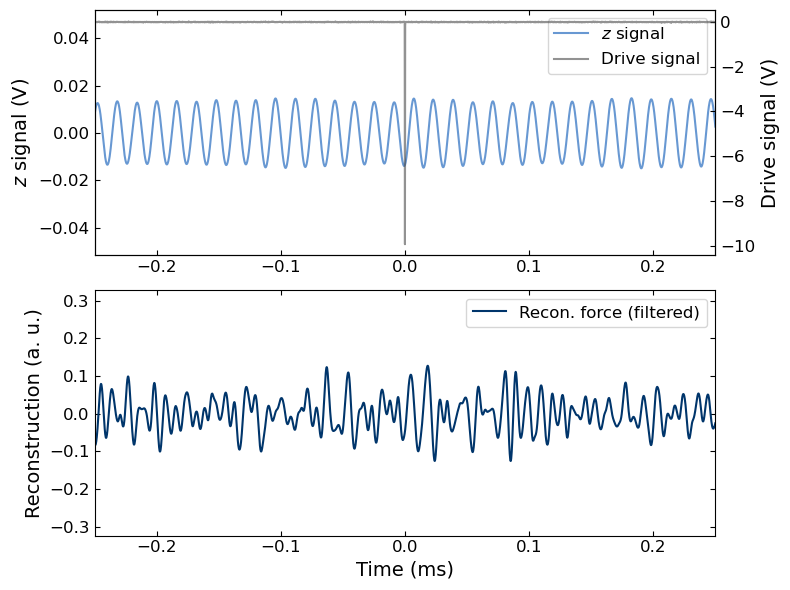

In [113]:
drive_indices = utils.get_pulse_idx(dd, -1, False)

idx = drive_indices[1]
a, b, c, d = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, True, None, 500000, 10000, search_window_length=40, pulse_length=30)

## Load calibration waveforms

Take ensemble average over 192 waveforms.

In [153]:
folder = r'/Users/yuhan/work/nanospheres/data/20241002_calibration_pulse_waveforms'
dataset = r''
combined_path = os.path.join(folder, dataset, '**/*.csv')
data_files = glob.glob(combined_path)

In [191]:
tt, dd, aa = [], [], []
for file in data_files:
    data = np.genfromtxt(file, delimiter=',', skip_header=2).T
    tt.append(data[0])  # time in us
    dd.append(data[1])  # V
    
    noise = np.mean(data[1]>0.8)
    area = np.trapz(data[1]-noise, data[0]*1e-6)
    aa.append(np.abs(area))

tt = np.asarray(tt)
dd = np.asarray(dd)
aa = np.asarray(aa)

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32409/676519698.py:10: SyntaxWarning: invalid escape sequence '\D'
  ax.text(400, -4, f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c\n(assume 120 V/m E field)', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32409/676519698.py:10: SyntaxWarning: invalid escape sequence '\p'
  ax.text(400, -4, f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c\n(assume 120 V/m E field)', fontsize=12)


Text(0, 0.5, 'Drive (V)')

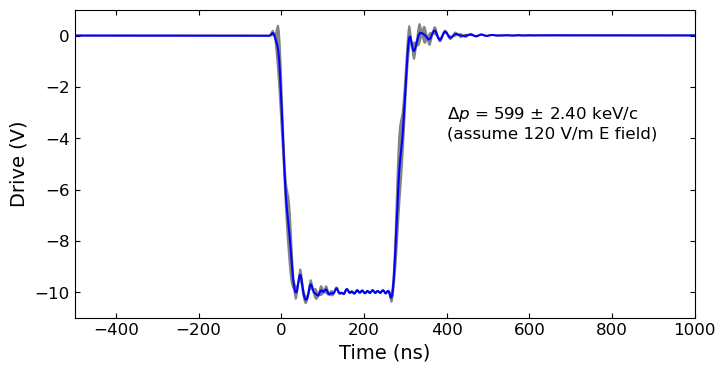

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mean = np.mean(dd, axis=0)
std = np.std(dd, axis=0)

amp_kev = np.mean(aa) * 120 * 6 * 1.602e-19 * SI2ev / 1000
amp_kev_std = np.std(aa) * 120 * 6 * 1.6e-19 * SI2ev / 1000

ax.fill_between(tt[0]*1000, mean-std, mean+std, color='grey', alpha=0.95)
ax.plot(tt[0]*1000, mean, color='blue')
ax.text(400, -4, f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV/c\n(assume 120 V/m E field)', fontsize=12)

ax.set_xlim(-500, 1000)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive (V)')

In [139]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:110: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz, \n'
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:111: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

## Reconstruct the pulses

In [202]:
folder = r'/Users/yuhan/work/nanospheres/data/20241001_six_e_data_backscatter'
datasets = ['20241001_10v_2e-8mbar_0_2_analog_gain']
pulseamps = [599]

unnormalized_amps = get_unnormalized_amps(folder, datasets, pulseamps, False)

20241001_10v_2e-8mbar_0_2_analog_gain


In [203]:
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20241001_10v_2e-8mbar_0_2_analog_gain


(None,
 <Axes: title={'center': 'Gain=0.2/30 (analog/digital), backscatter, 10 mV biased, short pulses'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

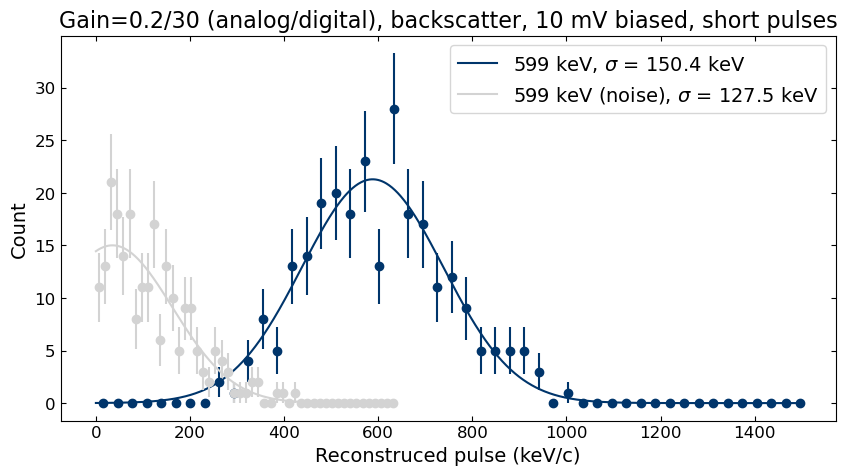

In [204]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]
hhs_n, bcs_n, gps_n = fit_amps_gaus(normalized_amps_noise)

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
fig, ax = plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Gain=0.2/30 (analog/digital), backscatter, 10 mV biased, short pulses')
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs_n, bcs_n, gps_n, noise=True, ax=ax, color='lightgrey')

## Estimate force noice right before the pulses arrive

Get a 8 ms window right before each pulse and estimate force noise

In [219]:
def get_window_before_pulse(tt, pulse_idx, length):
    window = np.full(tt.size, True)
    window[:pulse_idx-length] = False
    window[pulse_idx:] = False
    
    return window

In [209]:
folder = r'/Users/yuhan/work/nanospheres/data/20241001_six_e_data_backscatter'
datasets = ['20241001_10v_2e-8mbar_0_2_analog_gain']

dataset = datasets[0]
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

In [292]:
window_length = 40000
gamma = 125 * 2 * np.pi
passband = [40000, 100000]

ff_all, sf_all, sz_all = [], [], []
sig_p_kev = []

for file in data_files:
    dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
    fs = int(np.ceil(1/dtt))

    zz, dd = nn[0], nn[1]
    zz_bp = utils.bandpass_filtered(zz, fs, passband[0], passband[1])
    pulse_idx = utils.get_pulse_idx(dd, -0.5, False)
    
    for idx in pulse_idx:
        if idx < 100000 or idx > tt.size-100000:
            continue
         
        # Estimate PSD
        window = get_window_before_pulse(tt, idx, window_length)
        ff, pp = utils.get_psd(dt=dtt, zz=zz_bp[window], nperseg=2**18)
        
        all_idx = np.logical_and(ff > passband[0], ff < passband[1])
        ff_all.append(ff[all_idx])
        
        sz = pp[all_idx] * (c_mv**2)
        sz_all.append(sz)
        
        omega = ff[all_idx] * 2 * np.pi
        omega0 = omega[np.argmax(pp[all_idx])]
        
        chi = (1 / m) / (omega0**2 - omega**2 - gamma * omega * 1j)
        sf = sz / (np.abs(chi) * np.abs(chi))
        sf_all.append(sf)
        sig_p_kev.append(np.sqrt(1/(np.trapz(1/sf, x=omega)/(2*np.pi))) * SI2ev / 1000)

/Users/yuhan/anaconda3/envs/nanospheres/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 262144 is greater than input length  = 40000, using nperseg = 40000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Plot the first 50 force noise spectra.

<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32409/1762605179.py:14: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$S_f[\omega]$ (N$^2$/Hz)')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32409/1762605179.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('$\omega$/2$\pi$ (kHz)')


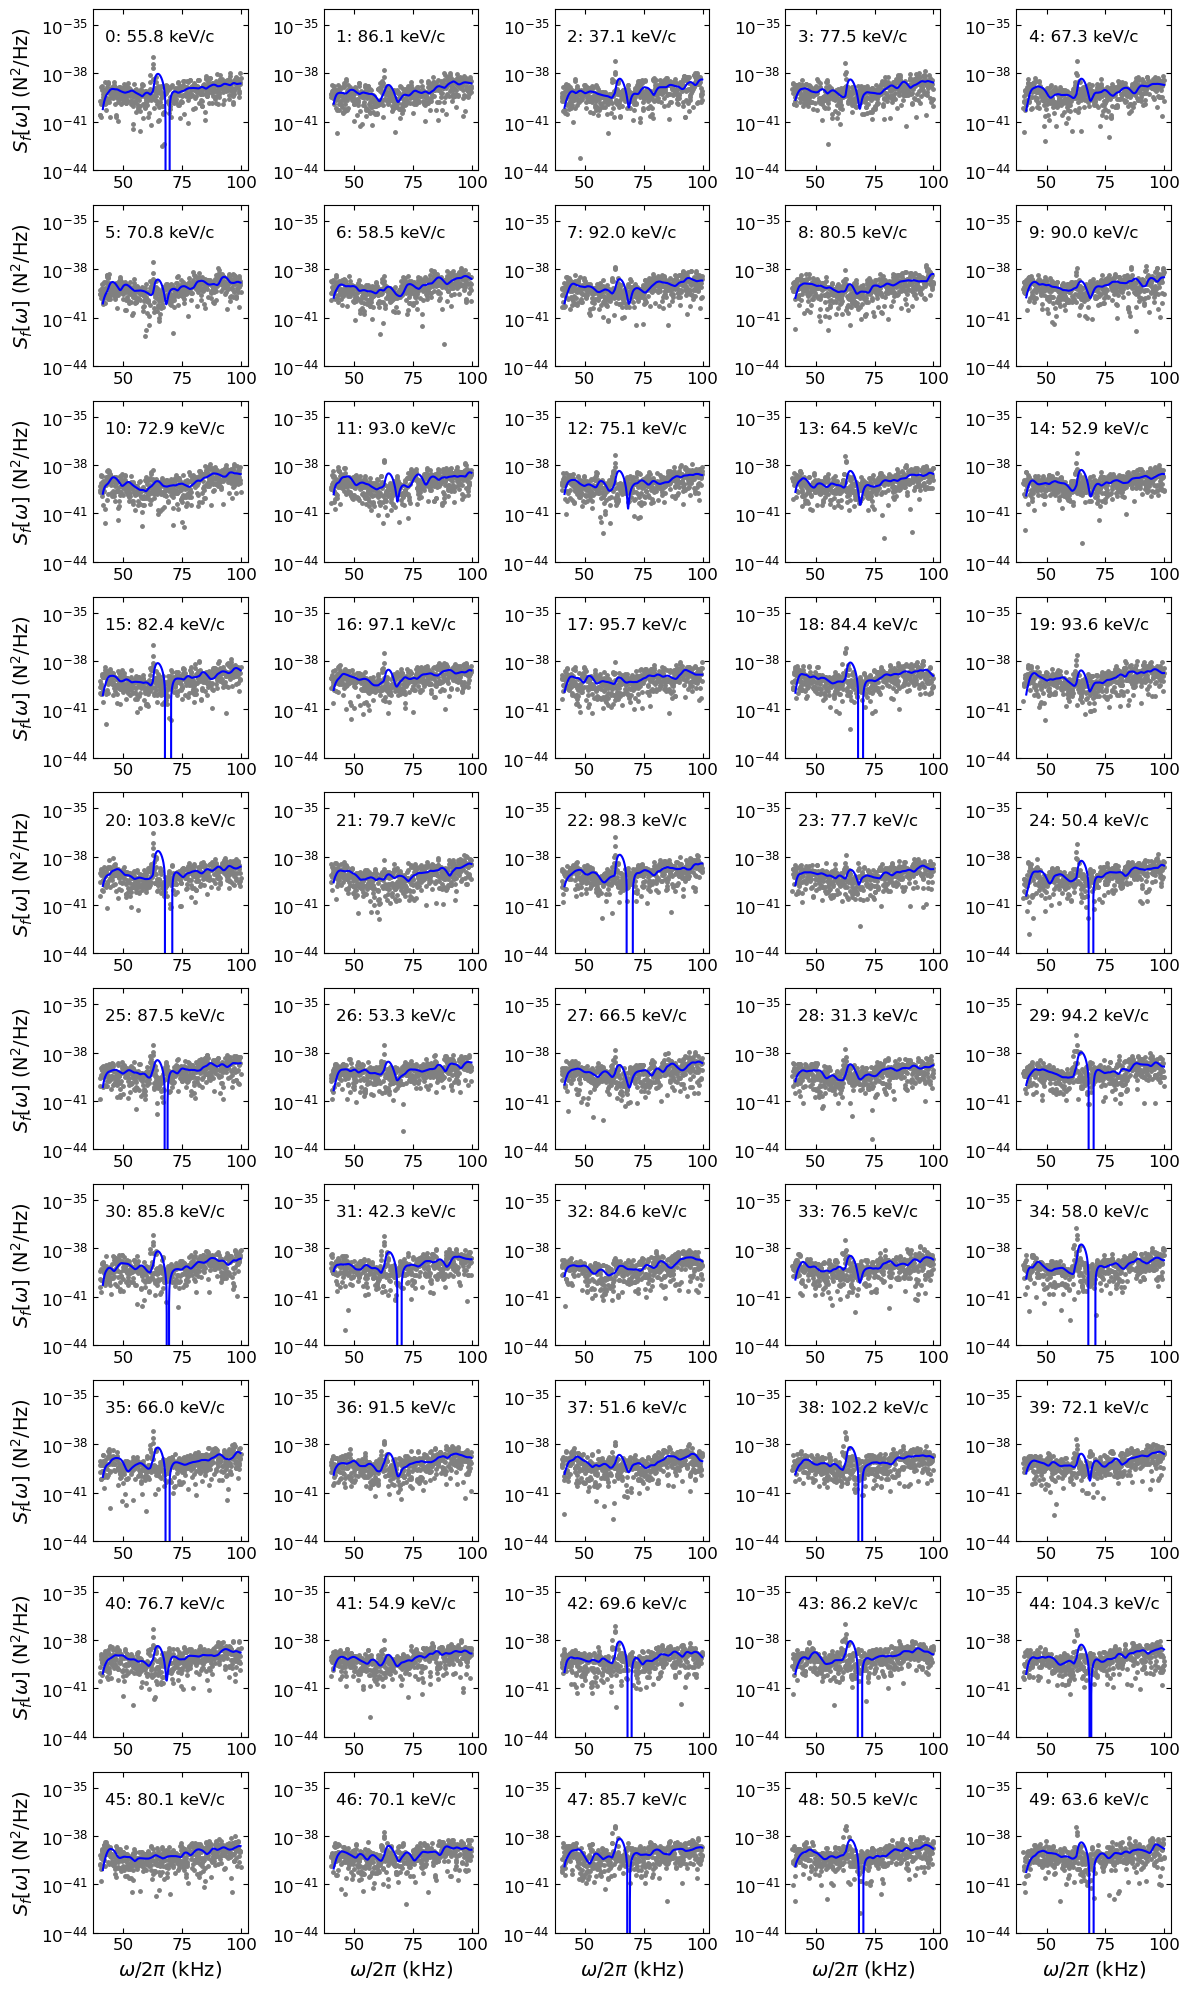

In [293]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(10, 5, figsize=(12, 20))
for i, ax in enumerate(axes.flatten()):
    ax.plot(ff_all[0]/1000, sf_all[i], '.', markersize=5, color='grey')
    ax.plot(ff_all[0][10:]/1000, utils.lowpass_filtered(sf_all[i], 200, 4)[10:], color='blue')
    
    ax.text(42.5, 1e-36, f'{i}: {sig_p_kev[i]:.1f} keV/c', fontsize=12)
    
    ax.set_yscale('log')
    ax.set_ylim(1e-44, 1e-34)

    if (i % 5 == 0):
        ax.set_ylabel('$S_f[\omega]$ (N$^2$/Hz)')
        
    if (i > 44):
        ax.set_xlabel('$\omega$/2$\pi$ (kHz)')
fig.tight_layout()

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32409/1763200366.py:7: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(xx, utils.gauss(xx, *gps_fn[0]), label=f'Estimated force noise: {gps_fn[0][1]:.1f} $\pm$ {gps_fn[0][2]:.1f} keV/c', color='blue')


Text(0, 0.5, 'Count')

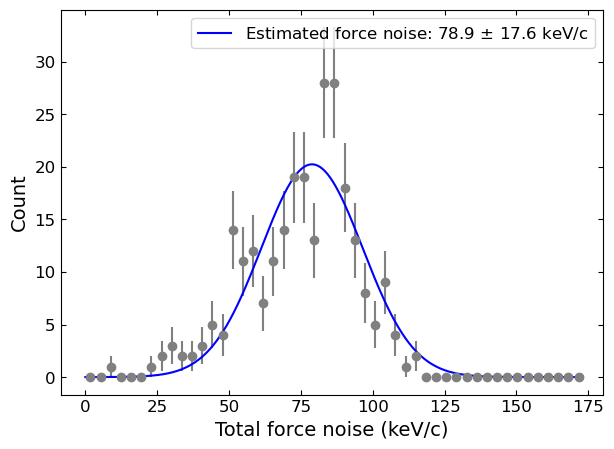

In [294]:
hhs_fn, bcs_fn, gps_fn = fit_amps_gaus([sig_p_kev])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(bcs_fn[0], hhs_fn[0], yerr=np.sqrt(hhs_fn[0]), fmt='o', color='grey')

xx = np.linspace(0, np.max(np.asarray(bcs_fn[0]).flatten()), 1000)
ax.plot(xx, utils.gauss(xx, *gps_fn[0]), label=f'Estimated force noise: {gps_fn[0][1]:.1f} $\pm$ {gps_fn[0][2]:.1f} keV/c', color='blue')
ax.legend(frameon=True, fontsize=12)
ax.set_xlabel('Total force noise (keV/c)')
ax.set_ylabel('Count')